<a href="https://colab.research.google.com/github/eduardokern/ML/blob/main/notebooks/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição do Desafio
Cálculo de Métricas de Avaliação de Aprendizado

Neste projeto, vamos calcular as principais métricas para avaliação de modelos de classificação de dados, como acurácia, sensibilidade (recall), especificidade, precisão e F-score. Para que seja possível implementar estas funções, você deve utilizar os métodos e suas fórmulas correspondentes (Tabela 1).

Para a leitura dos valores de VP, VN, FP e FN, será necessário escolher uma matriz de confusão para a base dos cálculos. Essa matriz você pode escolher de forma arbitraria, pois nosso objetivo é entender como funciona cada métrica.  

| Método         | Fórmula           |
|----------------|-------------------|
| Acurácia       | (VP+VN) / N       |
| Sensibilidade  | VP / (VP+FN)      |
| Especificidade | VN / (FP+VN)      |
| Precisão       | VP / (VP+FP)      |
| F-score        | 2 * (P*S) / (P+S) |

Tabela 1: Visão geral das métricas usadas para avaliar métodos de classificação. VP: verdadeiros positivos; FN: falsos negativos; FP: falsos positivos; VN: verdadeiros negativos; P: precisão; S: sensibilidade; N: total de elementos.


### Baixando o dataset

Será utilizado o dataset [Kaggle Cats and Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) a ser baixado pelo comando:

    curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
    unzip kagglecatsanddogs_5340.zip

In [2]:
!echo "Downloading kagglecatsanddogs_5340.zip for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!echo "Extracting images..."
!rm -rf PetImages
!unzip -qo kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!echo "Done."


############################################################################################# 100.0%
Extracting images...
Done.


### Python imports

Importando pacotes e módulos necessários para implementação do <b>Transfer Learning</b> com `keras`

Para visualização das imagens é importado o pacote `matplotlib`

In [14]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Categorias de imagens

Identificando a categoria das imagens a serem classificadas. Cada categoria está identificada em uma pasta diferente, utilizando o nome da pasta como categoria de imagem.

In [4]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


### Função get_image

A função abaixo carrega e pré processa uma image a ser utilizada no restante do projeto.

Mantendo a razão de aspecto da imagem uma vez que podem não ter a altura e largura idênticas.

A função `preprocess_input` é utilizada para padronizar e normalizar os dados de imagem, principalmente para utilizar em modelos pré treinados cujos consjuntos de treinamento seguiram o mesmo tipo de preprocessamento. Isto garante consistência e melhor resultado no desempenho do novo modelo.

In [5]:
# helper function to load image and return it and input vector
def get_image(path):
  try:
    img = image.load_img(path, target_size=(224, 224), keep_aspect_ratio=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
  except Exception as e:
    print(f'Error loading: {path}')
    return None, None

### Carregar imagens

O dataset contém cerca de 5000 imagens de cada categoria.
A máquina utilizada não dispõe de recurso para carregar todo o dataset, limitando a 1000 imagens (samples) de cada categoria.

As imagens são carregas a partir da pasta `root`.

Armazenando o caminho das imagens para apresnetação dos resultados.

In [6]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    idx = [int(len(data) * random.random()) for i in range(1000)]
    for img_path in images[:1000]:
        img, x = get_image(img_path)
        if img is not None:
          data.append({'x':np.array(x[0]), 'y':c, 'path': img_path})

# count the number of classes
num_classes = len(categories)
categories = [category.split('/')[1] for category in categories]
print(categories)

['Dog', 'Cat']


### Gerando imagens em ordem aleatória

Alterando a ordem das imagens de forma aleatória para se ter um conjunto de dados diferente a cada rodada e contendo dados alternadaos de cada categoria.

In [7]:
random.shuffle(data)

### Dataset de treinamento, validação e testes

- Treinamento: 70%,
- Validação: 15%,
- Testes: 15%

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

## Separando os dados e rótulos

Criando um `array` diferente para os dados e os labels, seguindo a mesma ordenação no array original.

In [9]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]


### Preprocessamento

- Garantir que é do tipo `float32` e está normalizado entre -1 e 1.
- Converter o array de labels para um `hot vector`.

In [10]:
# normalize data
x_train = x_train.astype('float32') /255.
x_val = x_val.astype('float32') /255.
x_test = x_test.astype('float32') /255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


### Resumo dos dados de treinamento

In [11]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


### Treinando a rede

A rede contém 4 camadas convolucionais alternadas e max-pooling, seguida por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada outro par conv/pooling. Após a última camada pooling, é anexada uma camada totalmente conectada de 256 neurônios, outra camada dropout, e finalmente uma camada de classificação softmax para as categorias.

A função `loss` será, comom de costume, `categorical cross-entropy loss`, e o algoritmos de treinamento será o [AdaDelta](https://arxiv.org/abs/1212.5701).

Após a compilação da rede executaremos `model.summary()` para pmostrar um snapshot de suas camadas.

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Foi criada uma rede de tamanho médio com ~1.2 milhões de pesos e biases (os parâmetros). A maioria deles leva a uma camada totalmente conectada pre-softmax "dense_5".

Agora é possível seguir para o treinamento do modelo para 10 épocas com um tamanho de lote de 128.

O histórico do treinamento será salvo para visualização do valor de `loss` ao longo do tempo.

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_val, y_val))


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4981 - loss: 0.7217 - val_accuracy: 0.5167 - val_loss: 0.6862
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.5229 - loss: 0.6842 - val_accuracy: 0.5600 - val_loss: 0.6610
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6081 - loss: 0.6551 - val_accuracy: 0.5867 - val_loss: 0.6507
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.6394 - loss: 0.6315 - val_accuracy: 0.5967 - val_loss: 0.6497
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6315 - loss: 0.6273 - val_accuracy: 0.6167 - val_loss: 0.6337
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6474 - loss: 0.6152 - val_accuracy: 0.6233 - val_loss: 0.6353
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6471 - loss: 0.6277 - val_accuracy: 0.6367 - val_loss: 0.6210
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.6935 - loss: 0.5902 - val_accuracy: 0.6

Calcular a matrix de confusão

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


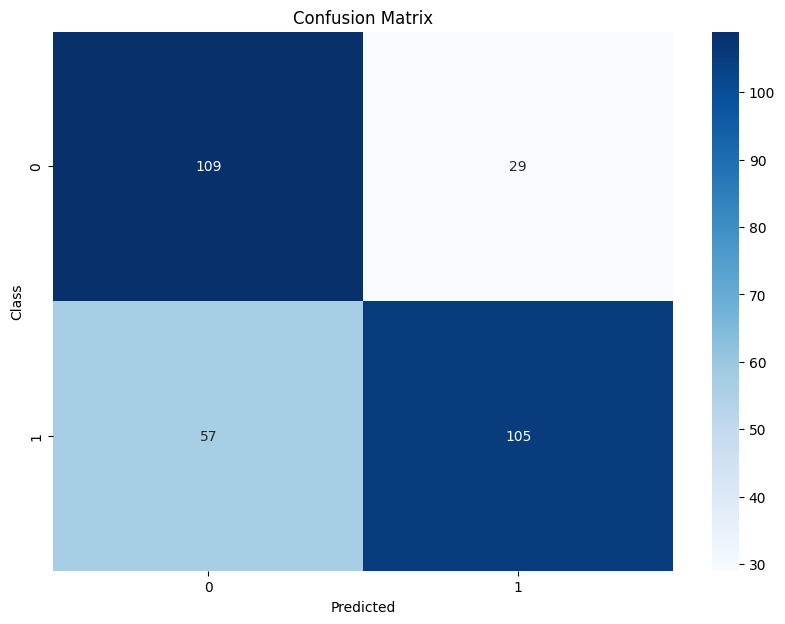

In [27]:
result = model.predict(x_test)
y_pred = np.argmax(result, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Class')
plt.title('Confusion Matrix')
plt.show()


### Calculando as métricas a partir da matriz de confusão

In [24]:
VP = cm[0][0]
VN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

print('VP: ', VP)
print('VN: ', VN)
print('FP: ', FP)
print('FN: ', FN)

print('\nMetrics')
# Accuracy
accuracy = (VP + VN) / (VP + VN + FP + FN)
print('- Accuracy: ', accuracy)

# sensitivity
sensitivity = VP / (VP + FN)
print('- Sensitivity: ', sensitivity)

# Specificity
specificity = VN / (FP + VN)
print('- Specificity: ', specificity)

# Precision
precision = VP / (VP + FP)
print('- Precision: ', precision)

# F-score
fscore = 2 * (precision * sensitivity) / (precision + sensitivity)
print('- F-score: ', fscore)


VP:  109
VN:  105
FP:  29
FN:  57

Metrics
- Accuracy:  0.7133333333333334
- Sensitivity:  0.6566265060240963
- Specificity:  0.7835820895522388
- Precision:  0.7898550724637681
- F-score:  0.7171052631578947
